### Bioneuron Oracle Notebook
#### April 2017
#### https://github.com/psipeter/bionengo/tree/oracle

Description of what the notebook does

### Install NEURON and other dependencies
change --prefix to your .local directory

```bash
pip install nengo matplotlib seaborn numpy

wget http://www.neuron.yale.edu/ftp/neuron/versions/v7.4/nrn-7.4.tar.gz
tar xzf nrn-7.4.tar.gz
cd nrn-7.4
./configure --prefix=/home/pduggins/.local --without-iv --with-nrnpython
make
(sudo) make install
cd src/nrnpython
python setup.py install
cd ../../..
```

### Install channel mechanisms for the bahl.hoc NEURON model
Change the path to your .local directory to compile the NEURONchannel mechanisms

```bash
git clone -b oracle https://github.com/psipeter/bionengo.git
cd bionengo/NEURON_models/
/home/psipeter/.local/x86_64/bin/nrnivmodl
```

In bahl.hoc, change nrn_load_dll path to NEURON_models/channels

### Define bioneuron class

In [533]:
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import neuron

neuron.h.load_file('/home/pduggins/bionengo/NEURON_models/bahl.hoc')

class BahlNeuron(nengo.neurons.NeuronType):
    '''compartmental neuron from Bahl et al 2012'''

    probeable=('spikes','voltage')
    def __init__(self,n_neurons,dimensions,encoders,syn_locations,label):
        super(BahlNeuron,self).__init__()
        self.n_neurons=n_neurons
        self.dimensions=dimensions
        self.encoders=encoders
        self.syn_locations=syn_locations
        self.label=label
        self.targets=None
        self.activities=None
        self.atrb={}
        self.inputs={}

    def create(self,bio_idx):
        return self.Bahl(bio_idx,self.encoders[bio_idx],syn_locations)

    class Bahl():
        def __init__(self,bio_idx,encoder,syn_locations):
            self.bio_idx=bio_idx
            self.encoder=encoder
            self.syn_locations=syn_locations
            self.bias = None
            self.synapses = {}
            self.netcons = {}
            self.cell = neuron.h.Bahl()
        def add_bias(self):
            self.bias_current = neuron.h.IClamp(self.cell.soma(0.5))
            self.bias_current.delay = 0
            self.bias_current.dur = 1e9
            self.bias_current.amp = self.bias
        def start_recording(self):
            self.v_record = neuron.h.Vector()
            self.v_record.record(self.cell.soma(0.5)._ref_v)
            self.ap_counter = neuron.h.APCount(self.cell.soma(0.5))
            self.t_record = neuron.h.Vector()
            self.t_record.record(neuron.h._ref_t)
            self.spikes = neuron.h.Vector()
            self.ap_counter.record(neuron.h.ref(self.spikes))
            self.spikes_last=[]
            
    def rates(self, x, gain, bias): #todo: remove this without errors
        return x

    def gain_bias(self, max_rates, intercepts): #todo: remove this without errors
        return np.ones(len(max_rates)),np.ones(len(max_rates))

    def step_math(self,dt,spiked,neurons,voltage,time):
        t_neuron=time*1000
        neuron.run(t_neuron) 
        new_spiked=[]
        new_voltage=[]
        for nrn in neurons:
            spike_times=np.array(nrn.spikes)
            spike_times_last=np.array(nrn.spikes_last)
            count=len(spike_times)-len(spike_times_last)
            new_spiked.append(count)
            volt=np.array(nrn.v_record)[-1] #fails if neuron.init() not called at right times
            new_voltage.append(volt)
            nrn.spikes_last=spike_times
        spiked[:]=np.array(new_spiked)/dt
        voltage[:]=np.array(new_voltage)

In [534]:
class ExpSyn():
    def __init__(self, sec, weight, tau, e_exc=0.0, e_inh=-80.0):
        self.type = 'ExpSyn'
        self.tau = tau
        self.e_exc = e_exc
        self.e_inh = e_inh
        self.syn = neuron.h.ExpSyn(sec)
        self.syn.tau=2*1000*self.tau #arbitrary 2x multiply to offset phase shift in bio decode
        self.weight = weight
        if self.weight >= 0.0: self.syn.e = self.e_exc
        else: self.syn.e = self.e_inh
        self.spike_in = neuron.h.NetCon(None, self.syn) #time of spike arrival assigned in nengo step
        self.spike_in.weight[0]=abs(self.weight)

### Nengo Operators and Builders

In [535]:
from nengo.builder import Builder, Operator, Signal

In [536]:
class SimBahlNeuron(Operator):
    def __init__(self,neurons,n_neurons,output,voltage,states):
        super(SimBahlNeuron,self).__init__()
        self.neurons=neurons
        self.neurons.father_op=self
        self.output=output
        self.voltage=voltage
        self.time=states[0]
        self.reads = [states[0]]
        self.sets=[output,voltage]
        self.updates=[]
        self.incs=[]
        self.label=self.neurons.label
        self.neurons.neurons=[self.neurons.create(i) for i in range(n_neurons)]
        self.inputs=self.neurons.inputs
        self.targets=self.neurons.targets
        self.activities=self.neurons.activities

    def make_step(self,signals,dt,rng):
        output=signals[self.output]
        voltage=signals[self.voltage]
        time=signals[self.time]
        def step_nrn():
            self.neurons.step_math(dt,output,self.neurons.neurons,voltage,time)
        return step_nrn

    def init_connection(self,inpt):
        for bionrn in range(len(self.neurons.neurons)):
            bioneuron=self.neurons.neurons[bionrn]
            input_decoders=self.inputs[inpt]['input_decoders']
            pre_neurons=input_decoders.shape[0]
            bioneuron.synapses[inpt]=np.empty((pre_neurons,n_syn),dtype=object)
            for pre in range(pre_neurons):
                for syn in range(n_syn):
                    decoder=input_decoders[bionrn]
                    encoder=bioneuron.encoder
                    location=bioneuron.syn_locations[pre][syn]
                    section=bioneuron.cell.apical(location)
                    weight=np.dot(decoder,encoder)
                    synapse=ExpSyn(section,weight,tau)
                    bioneuron.synapses[inpt][pre][syn]=synapse            
            bioneuron.start_recording() #todo - call elsewhere so it's not redundant
        neuron.init()


In [537]:
class TransmitSpikes(Operator):
    def __init__(self,ens_pre_label,spikes,bahl_op,states):
        self.ens_pre_label=ens_pre_label
        self.spikes=spikes
        self.bahl_op=bahl_op
        self.neurons=bahl_op.neurons.neurons
        self.time=states[0]
        self.reads=[spikes,states[0]]
        self.updates=[]
        self.sets=[]
        self.incs=[]
    def make_step(self,signals,dt,rng):
        spikes=signals[self.spikes]
        time=signals[self.time]
        def step():
            'event-based method'
            tback=time-dt
            t_neuron=tback*1000
            for n in range(spikes.shape[0]): #for each input neuron
                my_spikes=spikes[n] #actual spikes
                if my_spikes > 0: #if input neuron spiked
                    for nrn in self.neurons: #for each bioneuron
                        for syn in nrn.synapses[self.ens_pre_label][n]: #for each synapse conn. to input
                            syn.spike_in.event(t_neuron) #add a spike at time (ms)
        return step

In [538]:
from nengo.dists import get_samples
from nengo.builder.connection import build_decoders
from nengo.builder.connection import BuiltConnection

@Builder.register(BahlNeuron)
def build_bahlneuron(model,neuron_type,ens):
    model.sig[ens]['voltage'] = Signal(np.zeros(ens.ensemble.n_neurons),
                        name='%s.voltage' %ens.ensemble.label)
    op=SimBahlNeuron(neurons=neuron_type,
                     n_neurons=ens.ensemble.n_neurons,
                     output=model.sig[ens]['out'],
                     voltage=model.sig[ens]['voltage'],
                     states=[model.time])
    model.add_op(op)

@Builder.register(nengo.Ensemble)
def build_ensemble(model,ens):
    nengo.builder.ensemble.build_ensemble(model,ens)

@Builder.register(nengo.Connection)
def build_connection(model,conn):
    use_nrn = (
        isinstance(conn.post, nengo.Ensemble) and
        isinstance(conn.post.neuron_type, BahlNeuron))
    if use_nrn: #bioneuron connection
        rng = np.random.RandomState(model.seeds[conn])
        model.sig[conn]['in']=model.sig[conn.pre]['out']
        transform = get_samples(conn.transform, conn.size_out, d=conn.size_mid, rng=rng)
        eval_points, weights, solver_info = build_decoders(model, conn, rng, transform)
        op=conn.post.neuron_type.father_op
        op.inputs[conn.pre.label]={'input_decoders':weights.T}
        op.init_connection(conn.pre.label)
        model.add_op(
            TransmitSpikes(conn.pre_obj.label,model.sig[conn.pre]['out'],op,states=[model.time]))
        model.params[conn] = BuiltConnection(eval_points=eval_points,
                                             solver_info=solver_info,
                                             transform=transform,
                                             weights=weights)

    else: #normal connection
        return nengo.builder.connection.build_connection(model, conn)

Build a pre-simulation network to draw encoders and gains from Nengo

In [539]:
n_neurons=100
ens_seed=33
tau=0.01
dim=1
n_syn=1
dt=0.001
t_final=0.5
rng=np.random.RandomState(seed=333)

In [540]:
with nengo.Network(label='preliminary') as pre_model:
    stim = nengo.Node(lambda t: np.sin(t))
    pre_pre=nengo.Ensemble(n_neurons=100,dimensions=dim,seed=3,label='pre')
    pre_lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif',seed=ens_seed)
    nengo.Connection(stim,pre_pre,synapse=None)
    conn=nengo.Connection(pre_pre,pre_lif,synapse=tau)

with nengo.Simulator(pre_model,dt=dt) as pre_sim:
    pre_sim.run(0.001)
    
lif_encoders=pre_sim.data[pre_lif].encoders
lif_gains=pre_sim.data[pre_lif].gain
syn_locations=rng.uniform(0,1,size=(input_decoders.shape[0],n_syn))

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


todo: use Adreas' code to emulate biases by decoding them separately off the LIF population and adding it to the resulting connection weights

In [541]:
encoders=np.array([lif_encoders[i]*lif_gains[i] for i in range (n_neurons)])
encoders/=10.0
# encoders

## Simulation

In [542]:
with nengo.Network() as model:
    stim = nengo.Node(lambda t: np.sin(2*np.pi*t))
    pre=nengo.Ensemble(n_neurons=100,dimensions=dim,seed=3,label='pre')
    bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=ens_seed,
                       neuron_type=BahlNeuron(n_neurons,dim,encoders,syn_locations,'bio'))
    lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif',seed=ens_seed)
    direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')
    
    nengo.Connection(stim,pre,synapse=None)
    nengo.Connection(pre,bio,synapse=tau)
    nengo.Connection(pre,lif,synapse=tau)
    nengo.Connection(stim,direct,synapse=tau)
    
    probe_stim=nengo.Probe(stim,synapse=None)
    probe_pre=nengo.Probe(pre,synapse=tau)
    probe_lif=nengo.Probe(lif,synapse=tau)
    probe_direct=nengo.Probe(direct,synapse=tau)
    probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
    probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
    probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')

In [543]:
with nengo.Simulator(model,dt=dt) as sim:
    sim.run(t_final)

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:36.                                                 


### Plotting

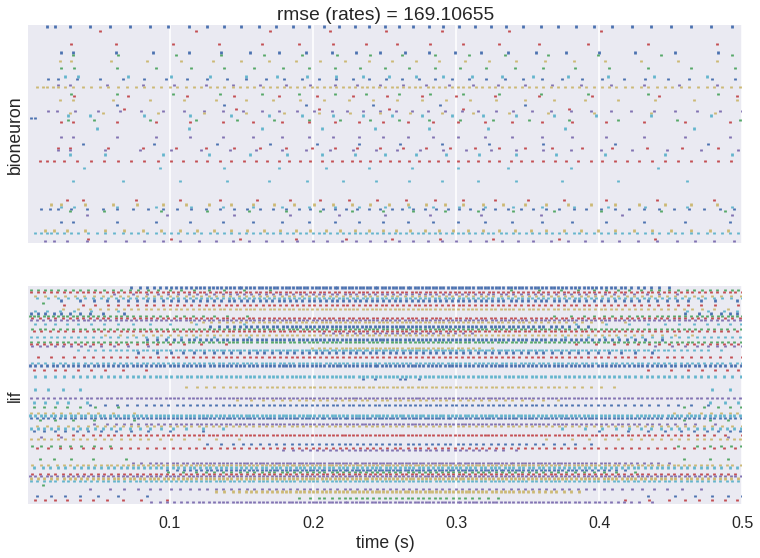

In [544]:
from nengo.utils.matplotlib import rasterplot
sns.set(context='poster')
bio_rates=np.array([nengo.Lowpass(tau).filt(
                    sim.data[probe_bio_spikes][:,nrn],dt=dt)
                    for nrn in range(sim.data[probe_bio_spikes].shape[1])]).T
lif_rates=np.array([nengo.Lowpass(tau).filt(
                    sim.data[probe_lif_spikes][:,nrn],dt=dt)
                    for nrn in range(sim.data[probe_lif_spikes].shape[1])]).T
rmse_rates=np.sqrt(np.average((bio_rates-lif_rates)**2))

figure, (ax1,ax2) = plt.subplots(2,1,sharex=True)
rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax1,use_eventplot=True)
ax1.set(ylabel='bioneuron',yticks=([]),title='rmse (rates) = %.5f'%rmse_rates)
rasterplot(sim.trange(),sim.data[probe_lif_spikes],ax=ax2,use_eventplot=True)
ax2.set(xlabel='time (s)',ylabel='lif',yticks=([]))
plt.show()

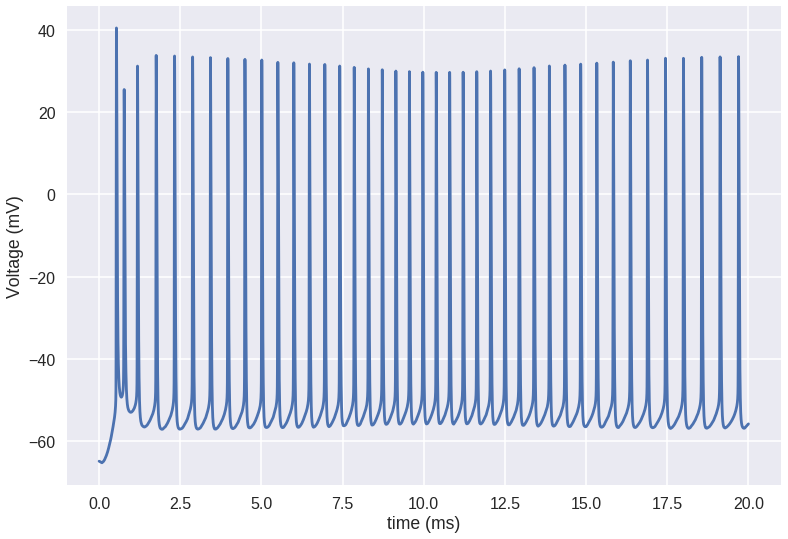

In [545]:
for nrn in range(1): #len(ens_bio.neuron_type.father_op.neurons.neurons)
    neuron=bio.neuron_type.father_op.neurons.neurons[nrn]
    figure,ax=plt.subplots(1,1)
    ax.plot(dt*np.arange(0,len(np.array(neuron.v_record))),np.array(neuron.v_record))
    ax.set(xlabel='time (ms)', ylabel='Voltage (mV)')
    plt.show()

{'time': 0.0019979476928710938, 'rmses': array([ 0.1940891])}


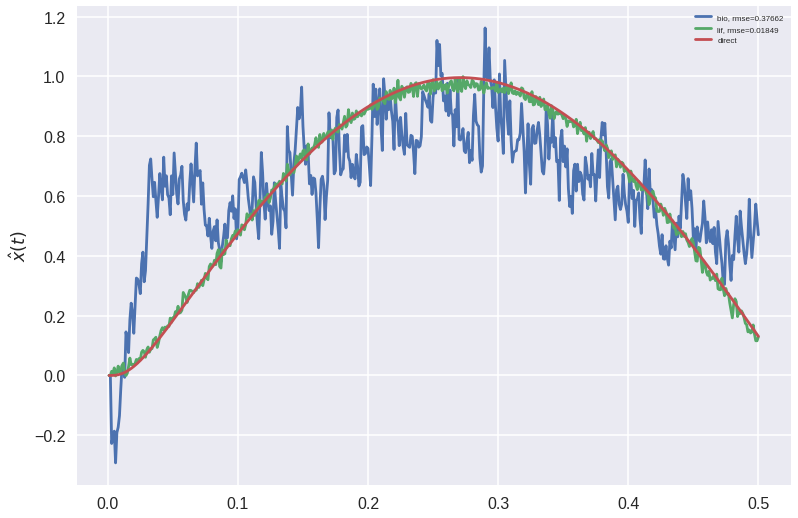

In [546]:
figure2,ax3=plt.subplots(1,1,sharex=True)
lpf = nengo.Lowpass(tau)
solver = nengo.solvers.LstsqL2(reg=0.01)
decoders_bio, info = solver(
                        lpf.filt(sim.data[probe_bio_spikes], dt=dt),
                        lpf.filt(sim.data[probe_pre], dt=dt)) #one filter on target
                        # lpf.filt(lpf.filt(sim.data[probe_pre], dt=P['dt_nengo']), dt=P['dt_nengo'])) @two filters on target
# np.savez(P['directory']+'ens_bio/decoders_ens_bio_to_probe.npz',decoders_bio=decoders_bio)
# decoders_bio=np.load(P['directory']+'ens_bio/decoders_ens_bio_to_probe.npz')['decoders_bio']
xhat_bio=np.sum(lpf.filt(sim.data[probe_bio_spikes], dt=dt)*decoders_bio.ravel(),axis=1)
print info

rmse_bio=np.sqrt(np.average((sim.data[probe_direct]-xhat_bio)**2))
rmse_lif=np.sqrt(np.average((sim.data[probe_direct]-sim.data[probe_lif])**2))
ax3.plot(sim.trange(),xhat_bio,label='bio, rmse=%.5f'%rmse_bio)
ax3.plot(sim.trange(),sim.data[probe_lif],label='lif, rmse=%.5f'%rmse_lif)
ax3.plot(sim.trange(),sim.data[probe_direct],label='direct')
ax3.set(ylabel='$\hat{x}(t)$')#,ylim=((ymin,ymax)))
legend3=ax3.legend(prop={'size':8})
plt.show()